# ASTRO 533 - Project 8

**Created:** Nov. 2020   
**Last Edit:** Nov. 2020  

**Author:** Bill Chen  
**Email:** ybchen@umich.edu  

## Load packages and read data

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from astropy.table import Table as tb
import astropy.coordinates as coord
import astropy.units as u
from astropy.units import cds
import copy
plt.style.use('bill')

my_YlGnBu = copy.copy(mpl.cm.get_cmap('YlGnBu')) # copy the default cmap
my_YlGnBu.set_bad('w')

my_magma = copy.copy(mpl.cm.get_cmap('magma'))
my_magma.set_bad(my_magma(-1))

nyu_cat = tb.read('lowz_catalog.dr4.fits', format='fits')
grp_gal = tb.read('SDSS_M_galaxy.dat', format='ascii')
grp_grp = tb.read('SDSS_M_group.dat', delimiter='\s',guess=False,format='ascii.no_header')

In [150]:
c = coord.SkyCoord(ra=nyu_cat['RA'],
                   dec=nyu_cat['DEC'], frame="icrs", unit="deg")
grp_c = coord.SkyCoord(ra=grp_gal['col4'],dec=grp_gal['col5'],frame="icrs", unit="deg")

# https://docs.astropy.org/en/stable/coordinates/matchsep.html
idx, d2d, d3d = coord.match_coordinates_sky(c, grp_c)
idx2, d2d2, d3d2 = coord.match_coordinates_sky(grp_c, c)
mtchd, = np.where(d2d.arcsec < 1)
print(len(grp_gal['col15'][idx[mtchd]]))

# make g-r_0.1 and stellar mass variables for later exploration/plotting. 
gr = np.zeros(len(c))-99.0
smass = np.zeros(len(c))-99.0
gr[mtchd]=grp_gal['col15'][idx[mtchd]]
smass[mtchd]=grp_gal['col14'][idx[mtchd]]

41215


In [10]:
# Now make halo masses and central/satellite tags
hmass = np.zeros(len(c))-99.0
grpid = np.zeros(len(c))-99.0
cen = np.full(len(c), False)
# Loop :(  Couldn't figure out a non-loop way.
for i,j in enumerate(grp_gal['col3'][idx[mtchd]]):
    gg, = np.where(grp_grp['col1']==j)
    hmass[mtchd[i]] = grp_grp['col6'][gg]
    grpid[mtchd[i]] = grp_grp['col1'][gg]
    if (grp_gal['col1'][idx[mtchd[i]]]==grp_grp['col2'][gg]): cen[mtchd[i]] = True

## Phase diagram of the most massive

In [337]:
id_max = np.argsort(hmass)[-1]
grp_id_max = np.where(grp_grp['col1']==grp_gal[idx[id_max]]['col3'])[0][0]
print('mass:', grp_grp['col6'][grp_id_max])
cen_id_max = np.where(grp_gal['col1']==grp_grp['col2'][grp_id_max])[0]
sat_id_max = np.where(grp_gal['col3']==grp_grp['col1'][grp_id_max])[0]

# sat_id_max = np.intersect1d(sat_id_max, idx[mtchd])

ra_cen = grp_gal['col4'][cen_id_max]
z_cmb_cen = grp_gal['col8'][cen_id_max]
L_cen = grp_gal['col13'][cen_id_max]
g_r_cen = grp_gal['col15'][cen_id_max]

ra = grp_gal['col4'][sat_id_max]
z_cmb = grp_gal['col8'][sat_id_max]
L = grp_gal['col13'][sat_id_max]
g_r = grp_gal['col15'][sat_id_max]

mass: 14.95


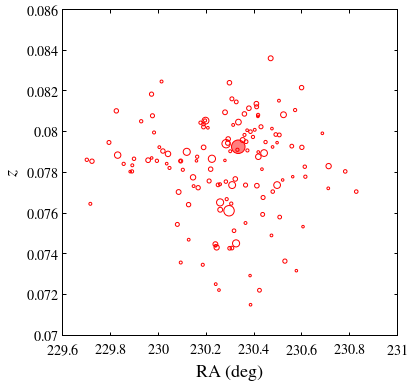

In [338]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(ra, z_cmb, s=10**(L-8.8), facecolor='', edgecolor='r', lw=1)
ax.scatter(ra_cen, z_cmb_cen, s=10**(L_cen-8.8), facecolor='r', edgecolor='', alpha=0.5)

ax.set_xlabel(r'$\rm RA\ (deg)$')
ax.set_ylabel(r'$z$')
ax.set_xlim(229.6, 231)
ax.set_ylim(0.07, 0.086)
ax.set_xticks([229.6, 229.8, 230, 230.2, 230.4, 230.6, 230.8, 231])
ax.set_xticklabels([r'$229.6$', r'$229.8$', r'$230$', r'$230.2$', r'$230.4$', r'$230.6$', r'$230.8$', r'$231$'])
ax.set_yticks([0.07, 0.072, 0.074, 0.076, 0.078, 0.08, 0.082, 0.084, 0.086])
ax.set_yticklabels([r'$0.07$', r'$0.072$', r'$0.074$', r'$0.076$', r'$0.078$', r'$0.08$', r'$0.082$', r'$0.084$', r'$0.086$'])

plt.savefig('./figures/phase.pdf')
plt.show()

In [339]:
H0 = 100*u.km/u.s/u.Mpc
d = cds.c*0.078/H0

print('d:', d.to(u.Mpc))

ind_valid = np.where(z_cmb>0.07)[0]

x = ra[ind_valid] * (np.pi/180) * d
v = (z_cmb[ind_valid]) * cds.c
print(np.mean(x.to(u.kpc)), np.std(x.to(u.kpc)))
print(np.mean(v.to(u.km/u.s)), np.std(v.to(u.km/u.s)))

print( np.log10( (5*np.std(x.to(u.kpc))*np.var(v.to(u.km/u.s))/cds.G).to(u.Msun).value ) )

d: 233.83811723999997 Mpc
939831.8095938314 kpc 920.8285062288151 kpc
23452.720224017663 km / s 713.6689547882341 km / s
14.736581280857422


## CMD

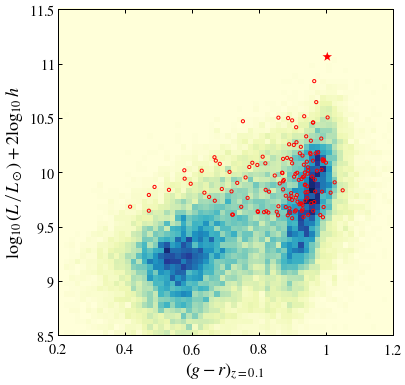

In [340]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist2d(grp_gal[idx[mtchd]]['col15'], grp_gal[idx[mtchd]]['col13'], range=[[0.2, 1.2], [8.5, 11.5]],
          bins = 60, cmap=my_YlGnBu)

ax.scatter(g_r, L, s=10, facecolor='', edgecolor='r', lw=1)
ax.scatter(g_r_cen, L_cen, s=100, facecolor='r', edgecolor='', marker='*')

ax.set_xlabel(r'$(g-r)_{z=0.1}$')
ax.set_ylabel(r'$\log_{10}\,(L\,\left/\,L_\odot\right.)+2\log_{10}\,h$')
ax.set_xlim(0.2, 1.2)
ax.set_ylim(8.5, 11.5)
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_xticklabels([r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$', r'$1.2$'])
ax.set_yticks([8.5, 9, 9.5, 10, 10.5, 11, 11.5])
ax.set_yticklabels([r'$8.5$', r'$9$', r'$9.5$', r'$10$', r'$10.5$', r'$11$', r'$11.5$'])

# plt.savefig('./figures/cmd.pdf')
plt.show()

## Low mass clusters

In [335]:
id_min = np.argsort(hmass)[np.random.randint(10000,20000, 100)]

cen_id_min = np.array([])
sat_id_min = np.array([])
for i in range(100):
    grp_id_min = np.where(grp_grp['col1'] == grp_gal[idx[id_min[i]]]['col3'])[0][0]
    cen_id_min = np.concatenate( (cen_id_min, np.where(grp_gal['col1']==grp_grp['col2'][grp_id_min])[0]) )
    sat_id_min = np.concatenate( (sat_id_min, np.where(grp_gal['col3']==grp_grp['col1'][grp_id_min])[0]) )
    
cen_id_min = np.int64(cen_id_min)
sat_id_min = np.int64(sat_id_min)

ra2_cen = grp_gal['col4'][cen_id_min]
z2_cmb_cen = grp_gal['col8'][cen_id_min]
L2_cen = grp_gal['col13'][cen_id_min]
g_r2_cen = grp_gal['col15'][cen_id_min]

ra2 = grp_gal['col4'][sat_id_min]
z2_cmb = grp_gal['col8'][sat_id_min]
L2 = grp_gal['col13'][sat_id_min]
g_r2 = grp_gal['col15'][sat_id_min]
print(len(sat_id_min))

104


In [362]:
print('mass:', np.sort(hmass)[10000])
print(len(cen_id_min)/len(sat_id_min))

mass: 11.166
0.9615384615384616


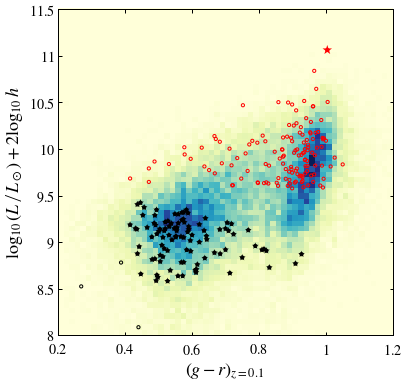

In [351]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist2d(grp_gal[idx[mtchd]]['col15'], grp_gal[idx[mtchd]]['col13'], range=[[0.2, 1.2], [8, 11.5]],
          bins = 60, cmap=my_YlGnBu)

ax.scatter(g_r, L, s=10, facecolor='', edgecolor='r', lw=1)
ax.scatter(g_r_cen, L_cen, s=100, facecolor='r', edgecolor='', marker='*')

ax.scatter(g_r2, L2, s=10, facecolor='', edgecolor='k', lw=1)
ax.scatter(g_r2_cen, L2_cen, s=50, facecolor='k', edgecolor='', marker='*')

ax.set_xlabel(r'$(g-r)_{z=0.1}$')
ax.set_ylabel(r'$\log_{10}\,(L\,\left/\,L_\odot\right.)+2\log_{10}\,h$')
ax.set_xlim(0.2, 1.2)
ax.set_ylim(8, 11.5)
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2])
ax.set_xticklabels([r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$', r'$1.2$'])
ax.set_yticks([8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5])
ax.set_yticklabels([r'$8$', r'$8.5$', r'$9$', r'$9.5$', r'$10$', r'$10.5$', r'$11$', r'$11.5$'])

plt.savefig('./figures/cmd.pdf')
plt.show()

In [307]:
ind_1 = np.where(nyu_cat['SERSIC_N'][:,2] < 2)[0]
ind_2 = np.where(nyu_cat['SERSIC_N'][:,2] > 2)[0]

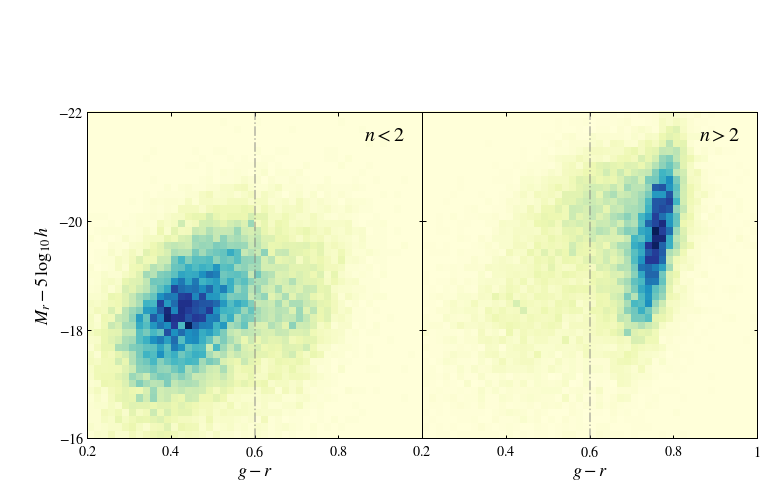

In [7]:
fig, [ax, ax2] = plt.subplots(1,2, figsize=(12,6), sharey=True)
fig.subplots_adjust(wspace=0)

ax.hist2d(nyu_cat['ABSMAG'][ind_1,1]-nyu_cat['ABSMAG'][ind_1,2], 
          nyu_cat['ABSMAG'][ind_1,2]-5*np.log10(1), range=[[0, 1], [-24, -16]],
          bins = 60, cmap=my_YlGnBu)
ax.axvline(0.6, c='gray', ls='-.', alpha=0.6)

ax2.hist2d(nyu_cat['ABSMAG'][ind_2,1]-nyu_cat['ABSMAG'][ind_2,2], 
          nyu_cat['ABSMAG'][ind_2,2]-5*np.log10(1), range=[[0, 1], [-24, -16]],
          bins = 60, cmap=my_YlGnBu)
ax2.axvline(0.6, c='gray', ls='-.', alpha=0.6)

ax.set_xlabel(r'$g-r$')
ax.set_ylabel(r'$M_r-5\,\log_{10}\,h$')
ax.set_xlim(0.2, 1)
ax.set_ylim(-16, -22)
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels([r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$'])
ax.set_yticks([-16, -18, -20, -22])
ax.set_yticklabels([r'$-16$', r'$-18$', r'$-20$', r'$-22$'])

ax2.set_xlabel(r'$g-r$')
ax2.set_xlim(0.2, 1)
ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_xticklabels([r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'])
ax.text(0.95, 0.96, r'$n<2$', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=20)
ax2.text(0.95, 0.96, r'$n>2$', transform=ax2.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=20)

plt.savefig('./figures/cmd2.pdf')
plt.show()